In [14]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
images = []
measurements = []

## load data with focusing at curves, rivers

In [16]:
def load_data_remove_zero(datafile):
    ''' 
    Return a dataframe with angle 0 removed
    '''
    data = pd.read_csv(datafile)
    # get indices of rows with steering angle of 0
    indices = []
    for i in data.index:
        steering = data.iloc[i, 3]
        if steering == 0:
            indices.append(i)
            
    index_to_remove = sorted(np.random.choice(indices, int(len(indices)), replace=False))

    # remove the rows with index above
    return data.drop(data.index[index_to_remove], inplace=False)

In [17]:
river = load_data_remove_zero('./data/riverside2/driving_log.csv')

In [18]:
# augmente the data and add them into images/measurements lists
for path, m in zip(river.iloc[:, 0], river.iloc[:, 3]):
    img_path = './data/riverside2/IMG/' + path.split('/')[-1]

    img = cv2.imread(img_path)[:,:,::-1] # covert from 'BGR'(cv2 default) to 'RGB'
    images.append(img)
    measurements.append(float(m))

    # flip the image over
    img_flipped = np.fliplr(img)
    images.append(img_flipped)
    measurements.append(-float(m))
    
assert len(images) == len(measurements)

Another set of data at curves

In [19]:
curves = load_data_remove_zero('./data/curves_good/driving_log.csv')

In [20]:
# augmente the data and add them into images/measurements lists
for path, m in zip(curves.iloc[:, 0], curves.iloc[:, 3]):
    img_path = './data/curves_good/IMG/' + path.split('\\')[-1]

    img = cv2.imread(img_path)[:,:,::-1] # covert from 'BGR'(cv2 default) to 'RGB'
    images.append(img)
    measurements.append(float(m))

    # flip the image over
    img_flipped = np.fliplr(img)
    images.append(img_flipped)
    measurements.append(-float(m))
    
assert len(images) == len(measurements)

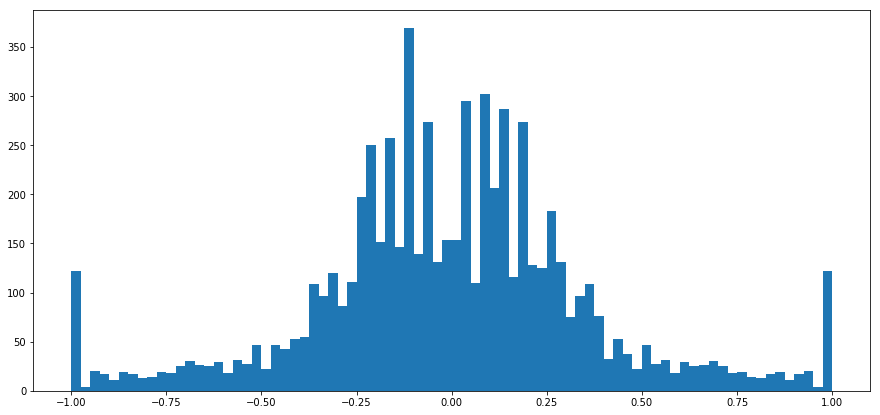

In [21]:
# visualise the histogram of above training steering angle
plt.figure(figsize=(15, 7))
_ = plt.hist(measurements, 80, rwidth=40, align='mid')

## load the large training dataset

In [22]:
def load_data(datafile):
    '''
    datafile: a relatively large training dataset
    Return: dataframe of balanced data
    '''
    # skipped first row since udacity's data contains header but my own data does not
    data = pd.read_csv(datafile)
    # get indices of rows with steering angle less than 0.05
    indices_05 = []
    # get indices of rows with steering angle between 0.05 and 0.1
    indices_1 = []
    # get indices of rows with steering angle between 0.1 and 0.2
    indices_2 = []
    # get indices of rows with steering angle between 0.2 and 0.3
    indices_3 = []       
    # get indices of rows with steering angle of 0
    indices_zero = []
    for i in data.index:
        steering = data.iloc[i, 3]
        if steering == 0:
            indices_zero.append(i)
        elif -0.05 < steering < 0.05:
            indices_05.append(i)
        elif -0.1 < steering < 0.1:
            indices_1.append(i)
        elif -0.2 < steering < 0.2:
            indices_2.append(i)
        elif -0.3 < steering < 0.3:
            indices_3.append(i)

    index_to_remove_zero = np.random.choice(indices_zero, int(0.9*len(indices_zero)), replace=False)
    index_to_remove_05 = np.random.choice(indices_05, int(0.8*len(indices_05)), replace=False)
    index_to_remove_1 = np.random.choice(indices_1, int(0.8*len(indices_1)), replace=False)
    index_to_remove_2 = np.random.choice(indices_2, int(0.2*len(indices_2)), replace=False)
    index_to_remove_3 = np.random.choice(indices_3, int(0.001*len(indices_3)), replace=False)

    total_to_remove = np.concatenate((index_to_remove_zero, 
                                     index_to_remove_05, 
                                     index_to_remove_1,
                                     index_to_remove_2,
                                     index_to_remove_3))

    # remove the rows with index above
    
    return data.drop(data.index[total_to_remove], inplace=False)   

In [23]:
data = load_data('./data_mouse/driving_log.csv')

In [24]:
# augmente the data and add them into images/measurements lists
for path, m in zip(data.iloc[:, 0], data.iloc[:, 3]):
    img_path = './data_mouse/IMG/' + path.split('/')[-1]

    img = cv2.imread(img_path)[:,:,::-1] # covert from 'BGR'(cv2 default) to 'RGB'
    images.append(img)
    measurements.append(float(m))

    # flip the image over
    img_flipped = np.fliplr(img)
    images.append(img_flipped)
    measurements.append(-float(m))
    
assert len(images) == len(measurements)

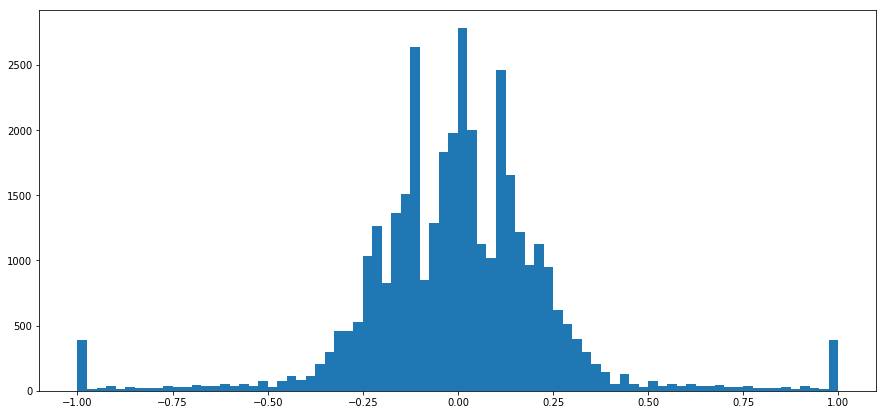

In [25]:
# visualise the histogram of above training steering angle
plt.figure(figsize=(15, 7))
_ = plt.hist(measurements, 80, rwidth=40, align='mid')

In [26]:
print(cv2.__version__)

3.1.0


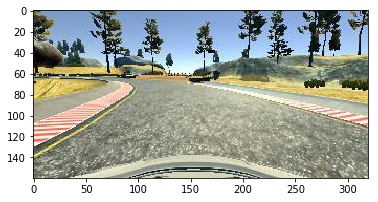

In [33]:
plt.imshow(images[10])

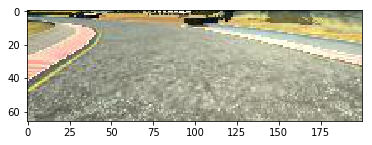

In [34]:
plt.imshow(images[10][60:126,55:255])

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Dropout, Cropping2D
from keras.optimizers import Adam

In [ ]:
drop_prob = 0.5
# nvidia
model = Sequential()
### preprocessing layer
# cropping2D layer
model.add(Cropping2D(cropping=((60, 34), (55, 65)), input_shape=(160, 320, 3)))
# normalisation and centraling
model.add(Lambda(lambda x: x / 255.0 - 0.5))

# conv1 depth: 24, kernel=5*5
model.add(Conv2D(24, 5, 5, subsample=(2,2), activation='relu'))
# dropout
model.add(Dropout(drop_prob))

# conv2 depth: 36, kernel=5*5
model.add(Conv2D(36, 5, 5, subsample=(2,2) , activation='relu'))
# dropout
model.add(Dropout(drop_prob))

# conv3 depth: 48, kernel=3*3
model.add(Conv2D(48, 5, 5, subsample=(2,2) , activation='relu'))
# dropout
model.add(Dropout(drop_prob))

model.add(Conv2D(64, 3, 3, border_mode='valid', activation='relu'))
# dropout
# model.add(Dropout(drop_prob))

model.add(Conv2D(64, 3, 3, border_mode='valid', activation='relu'))
# dropout
model.add(Dropout(drop_prob))

# Flatten
model.add(Flatten())

# FC1
model.add(Dense(1164, activation='relu'))
#model.add(Dropout(drop_prob))



# FC2
model.add(Dense(100, activation='relu'))
#model.add(Dropout(drop_prob))

# FC3
model.add(Dense(50, activation='relu'))
#model.add(Dropout(drop_prob))

# FC3
model.add(Dense(10, activation='relu'))
#model.add(Dropout(drop_prob))

model.add(Dense(1))



model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()